<a href="https://colab.research.google.com/github/Hema-kolla/Projects-on-ML-and-NLP/blob/main/Hotel_review_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [3]:
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
from textblob import Word
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score




In [4]:
# WordCloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [5]:
df=pd.read_csv("/content/Data Analyst - Test Data - US.csv")

In [6]:
df.shape

(6448, 3)

In [7]:
df.columns

Index(['Review', 'date', 'Location'], dtype='object')

In [8]:
features=['Review', 'date', 'Location']

In [9]:
df=df[features]

In [10]:
df.isnull().sum()

Review        55
date           0
Location    4737
dtype: int64

In [11]:
import nltk
from nltk import FreqDist
import re
import spacy

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6448 entries, 0 to 6447
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Review    6393 non-null   object
 1   date      6448 non-null   object
 2   Location  1711 non-null   object
dtypes: object(3)
memory usage: 151.2+ KB


In [13]:
df.describe()

,Review,date,Location
count,6393,6448,1711
unique,6384,403,1082
top,Amazing\n \n Read more\n Read less,Jun 2019,United States of America
freq,4,145,116


In [14]:
df.head()


,Review,date,Location
0,I was very impressed with the resort.\n Great ...,2019/08/20,Sebastian
1,The rooms were nice the outside needs work als...,2019/08/20,Los Angeles
2,Great location! I have stayed at this hotel on...,2019/08/20,Georgia
3,The hotel was adequate for my stay. The strips...,2019/08/20,NaN
4,"Great location, room was large and spacious. P...",2019/08/19,Palm Harbor


Data ranges from 2018 January to 2021 Dec.

In USA people are more interested in pools more than other places
Similarly in Californa, Canada and UK, location, closeness to airport are important

In [15]:
df.dropna(subset=['Review'], inplace=True)

In [55]:
df.dropna(subset=['Location'], inplace=True)

In [137]:
df.Review.replace({r'\n\nRead more\nRead less':''}, regex=True, inplace=True)

In [138]:
data = pd.Series([x for x in df.Review])

In [139]:
len(data)

1705

In [140]:
df['Location'].value_counts()[:10]

United States of America    116
New York                     34
San Jose                     19
California                   19
Florida                      16
Canada                       16
United Kingdom               14
New York, NY                 13
Toronto                      12
Miami                        12
Name: Location, dtype: int64

In [141]:
data = data.str.replace("[^a-zA-Z#]", " ")

<ipython-input-141-3d38353ac1fd>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data = data.str.replace("[^a-zA-Z#]", " ")


In [142]:
data

0       I was very impressed with the resort   Great s...
1       The rooms were nice the outside needs work als...
2       Great location  I have stayed at this hotel on...
3       Great location  room was large and spacious  P...
4       Very clean and friendly and I love the locatio...
                              ...                        
1700     the staff were all so friendly  frank  the ch...
1701            the internet barely worked or didn t work
1702     the location was great            the bed was...
1703     we were early for check in and the staff was ...
1704     staff  free coffee  location and activities  ...
Length: 1705, dtype: object

In [143]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [144]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def remove_stopwords(sent: list) -> str:
    """
    A function to remove stopwords
    """
    sent_new = " ".join([w for w in sent if w.lower() not in stop_words])
    return sent_new

In [145]:
# remove stopwords from our data
data_2 = [remove_stopwords(r.split()) for r in data]

In [146]:
def plot_word_freq(corpus, n_words = 20):
    """
    a function to plot the most frequently occurring words in a corpus
    """
    all_words = ' '.join([text for text in corpus])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    # plot frequency of top n most frequent words
    d = words_df.nlargest(columns="count", n = n_words)
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

Reviews


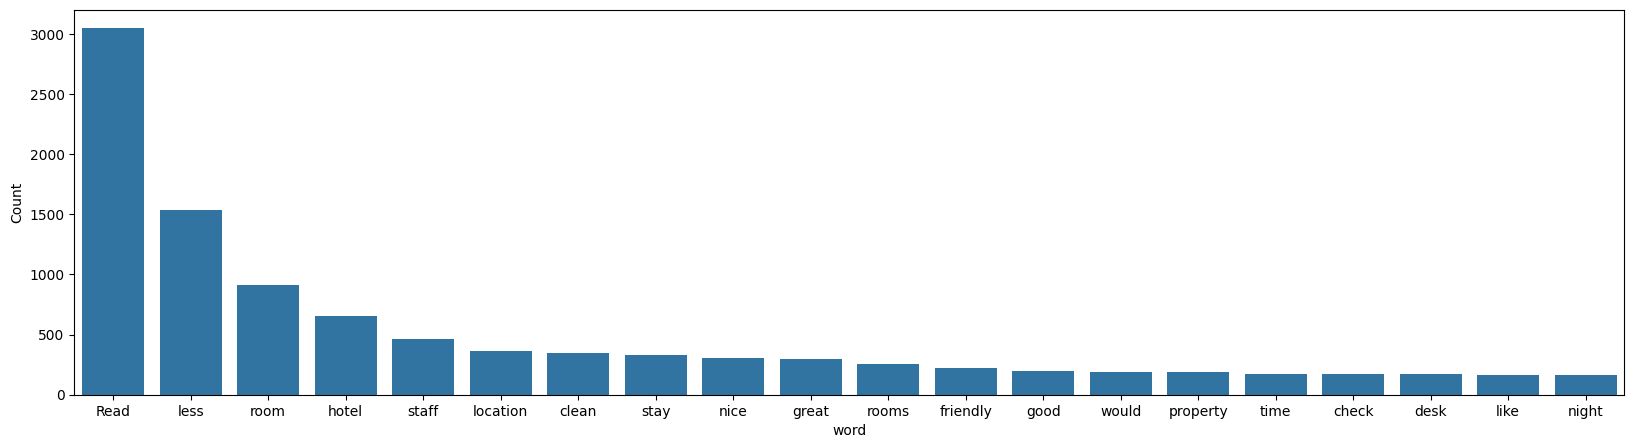

In [148]:
print("Reviews")
plot_word_freq(data_2)

People talk about 'location','room' and 'staff' the most.

In [65]:
def make_wordcloud(corpus, color = 'black'):
    """
    A function to create a word cloud from a corpus of words
    """
    words = ' '.join(corpus)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    return wordcloud

Text(0.5, 1.0, 'Reviews')

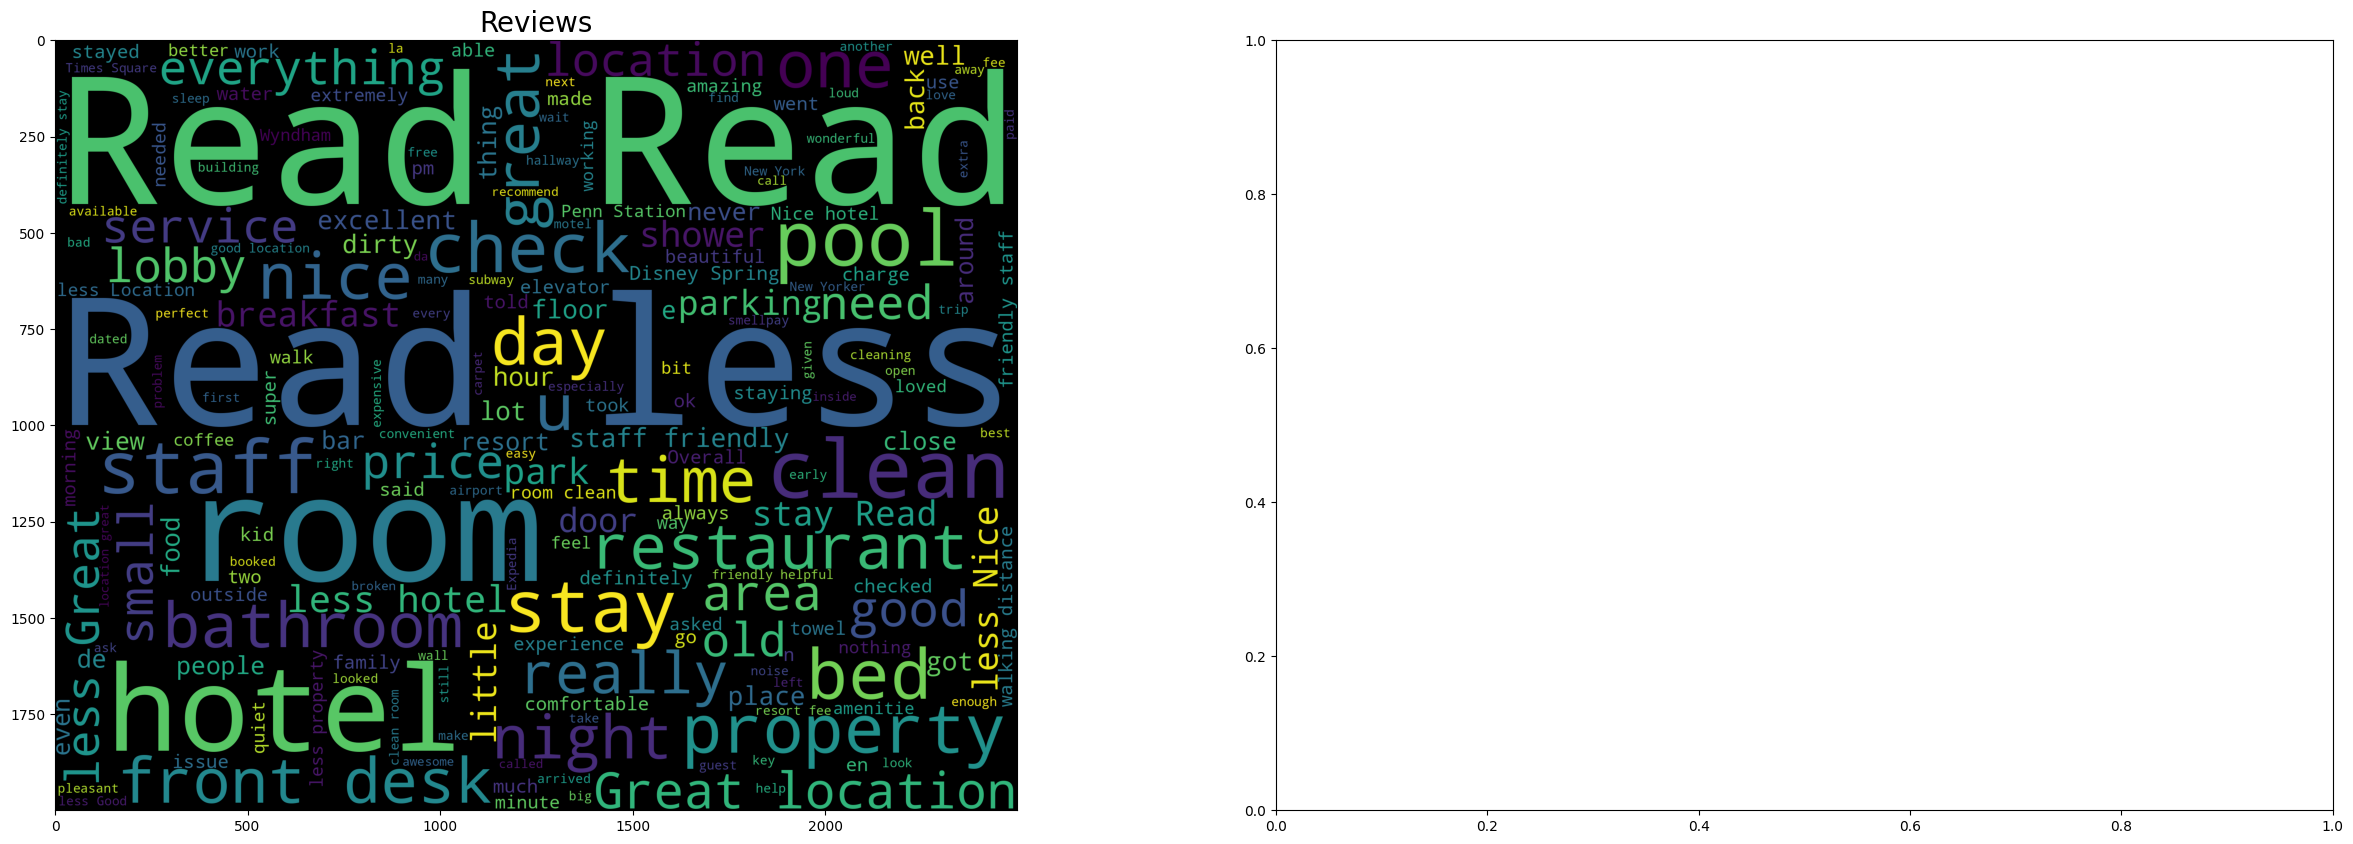

In [66]:
wordcloud = make_wordcloud(data_2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))
axes[0].imshow(wordcloud)
axes[0].set_title("Reviews",fontdict={"fontsize":20})


The most common words main word cloud were:

great
location
staff
room
pool
breakfast
This says that the customers are happy with the staff and they also appreciate the friendly and helpful staff. The location of the hotel is also a plus, as is the pool and breakfast.

In [67]:
from sklearn.model_selection import train_test_split
import transformers
from transformers import (
    BertModel,
    BertTokenizer,
    AdamW,
    get_linear_schedule_with_warmup,
)
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [68]:
bert_model_name = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

In [30]:
data_df = pd.DataFrame.from_dict({"review":list(data),"sentiment":[1 for x in data]})
reviews = pd.concat([data_df],axis=0)

In [70]:
reviews


,review,sentiment
0,I was very impressed with the resort Great s...,1
1,The rooms were nice the outside needs work als...,1
2,Great location I have stayed at this hotel on...,1
3,The hotel was adequate for my stay The strips...,1
4,Great location room was large and spacious P...,1
...,...,...
6388,the staff were all so friendly frank the ch...,1
6389,the internet barely worked or didn t work,1
6390,the location was great the bed was...,1
6391,we were early for check in and the staff was ...,1


In [71]:
dev, test = train_test_split(reviews, test_size=0.1, random_state = 100)  # splitting into dev and test sets
train, val = train_test_split(reviews, test_size=0.222222, random_state = 100)

In [72]:
# reset the indices
train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)

In [73]:
test

,review,sentiment
0,Really enjoyed our time by the pool R...,1
1,Superbe tablissement et bien plac au sud de ...,1
2,We are SoCal residents and Disney pass holders...,1
3,the hotel itself was nice location was a litt...,1
4,Muy buena habitaci n Read more Read less,1
...,...,...
635,The whole hotel smells awful the place is dark...,1
636,The hotel is clean and the staff friendly and ...,1
637,Liked the location of the property Close to U...,1
638,The rooms are accessed outdoors by balconies ...,1


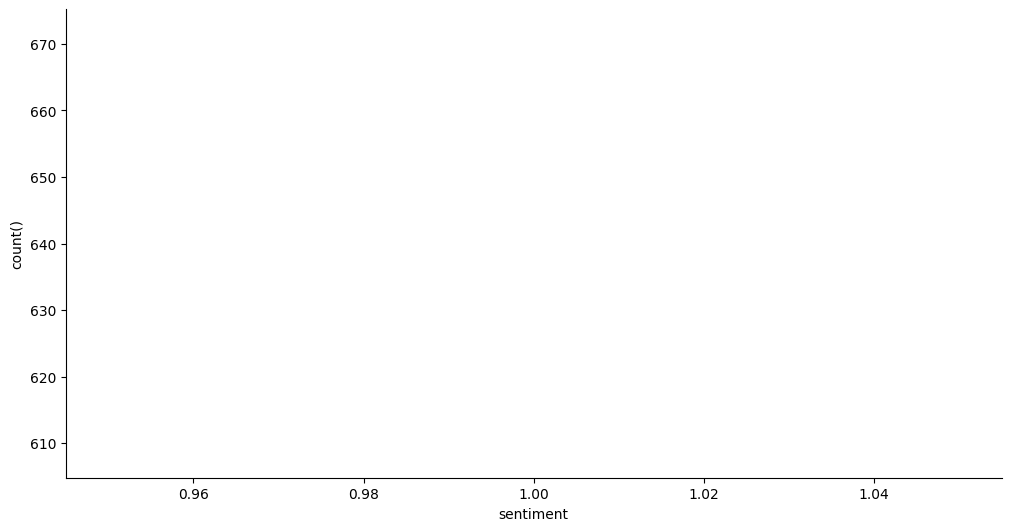

In [74]:
# @title sentiment vs count()

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['sentiment']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'sentiment'}, axis=1)
              .sort_values('sentiment', ascending=True))
  xs = counted['sentiment']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = test.sort_values('sentiment', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('sentiment')
_ = plt.ylabel('count()')

In [75]:
all_tokens = [tokenizer.tokenize(x) for x in reviews.review]

<ipython-input-76-4ab5d8bb9767>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot([len(x) for x in all_tokens])


Text(0.5, 1.0, 'Distribution of Tokenized Review Lengths')

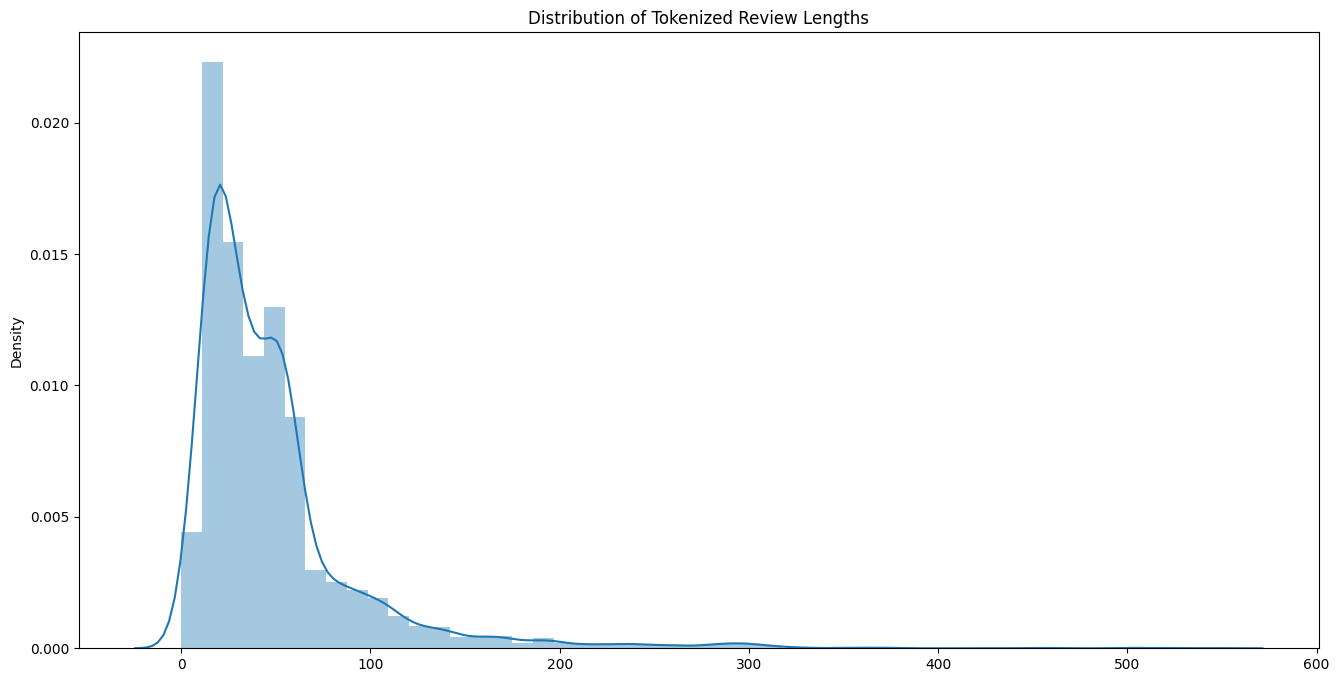

In [76]:
plt.figure(figsize = (16,8))
sns.distplot([len(x) for x in all_tokens])
plt.title("Distribution of Tokenized Review Lengths")

In [40]:
df.columns

Index(['Review', 'date', 'Location'], dtype='object')

In [89]:
df['Location'].count()

1705

In [130]:
df['Review'].count()

1705

The hotel appears to be having an overall positive review from the guests.